## Imports

In [72]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle

import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

from DS_2_2024_HW2_efficient_net import EfficientNet

In [73]:
tf.keras.utils.set_random_seed(16)

## Data

In [74]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

In [78]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")
    
# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

with open("hw2_outofsample.pickle", 'rb') as f:
    test = pickle.load(f)
test = tf.data.Dataset.from_tensor_slices(test) # see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [80]:
dev

<MapDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'mask': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)}>

# Build Model

Continue by initializing EfficientNet, building the model, augmentation and training.

In [77]:
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition

# Create the EfficientNet model
base_model = EfficientNet(
    default_resolution=(224),
    width_coefficient=1.0,
    depth_coefficient=1.0,
    include_top=False,
    weights='efficientnet.h5',
    dropout_rate=0.2
)

# Summary of the model architecture
base_model.summary()

Model: "efficientnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                      

In [6]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization): #BatchNormalization layers are typically kept trainable to allow them to adapt during fine-tuning.
        layer.trainable = True
    else:
        layer.trainable = False

# We don't want to print out all the layers again, only number of (non-)trainable parameters
def custom_summary(model):
    total_params = model.count_params()
    trainable_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable_params = total_params - trainable_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

# Call the custom summary function
custom_summary(base_model)

Total parameters: 4049564
Trainable parameters: 42016
Non-trainable parameters: 4007548


In [38]:
inputs = tf.keras.layers.Input([H, W, C])
hidden = base_model(inputs)[0]

dense = tf.keras.layers.Dense(32, activation=tf.nn.relu)(hidden)

# Dropout and fully connected
dense = tf.keras.layers.Dropout(0.2)(dense)

outputs = tf.keras.layers.Dense(34, activation=tf.nn.softmax)(dense)

model = tf.keras.Model(inputs, outputs)
model.summary()
#Is that not problematic (None as first param)?

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense_5 (Dense)             (None, 32)                40992     
                                                                 
 dense_6 (Dense)             (None, 34)                1122      
                                                           

In [8]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through Efficient model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

inputs = tf.keras.layers.Input([H, W, C])
hidden = base_model(inputs)[0]
#hiden = ...

In [101]:
#Pre-processing pipeline
# Define data augemtation
#resized_cvd = cats_vs_dogs.map(lambda x, y: (tf.image.resize(x, size), y))

#Není potřeba?
dog_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
    ]
)

In [49]:
dense

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dense_5')>

In [102]:
#Visual check - not working RN

for images, labels in resized_cvd.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        augmented_image = dog_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

NameError: name 'resized_cvd' is not defined

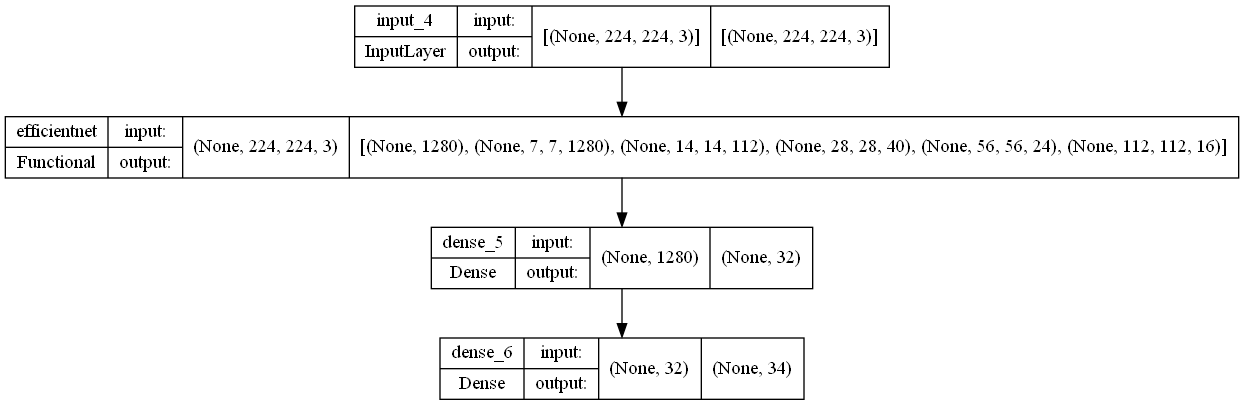

In [46]:
#Extra ze cvičení

# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [28]:
# Label smoothing

def label_smooth_train(image, labels, alpha, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    labels *= (1 - alpha)
    labels += alpha / n_labels
    return image, labels

def label_smooth_dev(image, labels, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    return image, labels

In [29]:
def map_to_tuple(element):
    image = element['image']
    label = element['label']
    mask = element['mask']
    return image, label

In [50]:
# Create batches with label smoothing
batch_size = 224
smooth_alpha = 0.05
n_labels = LABELS
image_size = (224, 224)

train_ds = train.map(map_to_tuple)
validation_ds = dev.map(map_to_tuple)

#train_ds = train_ds.map(lambda x, y: label_smooth_train(x, y, smooth_alpha, n_labels))
#validation_ds = validation_ds.map(lambda x, y: label_smooth_dev(x, y, n_labels))

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [82]:
train

<MapDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'mask': TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)}>

In [70]:
def map_fn(ser_example):
    feature = {
        'image': tf.io.FixedLenFeature([W,H,C], tf.float32),
        'label': tf.io.FixedLenFeature([1], tf.int64)
    }
    example = tf.io.parse_single_example(ser_example, feature)
    return example['image'],example['label']

train_ds = train.map(map_fn)

TypeError: in user code:

    File "C:\Users\vojta\AppData\Local\Temp\ipykernel_11940\2925728153.py", line 6, in map_fn  *
        example = tf.io.parse_single_example(ser_example, feature)

    TypeError: Expected any non-tensor type, but got a tensor instead.


In [67]:
# Create batches with label smoothing
batch_size = 224
smooth_alpha = 0.05
n_labels = LABELS
image_size = (224, 224)

train_ds = train.map(map_to_tuple)
validation_ds = dev.map(map_to_tuple)

#train_ds = train_ds.map(lambda x, y: label_smooth_train(x, y, smooth_alpha, n_labels))
#validation_ds = validation_ds.map(lambda x, y: label_smooth_dev(x, y, n_labels))

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, image_size), y))

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)

TypeError: Missing required positional argument

In [51]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())


#Note - doporučuje smoothing po augment train?

In [83]:
# We define pipeline that will consist of augmentation and batching

def augment_train(input):
    image = input['image']
    label = input['label']
    
    # Augmentation procedures (modify to your wish)

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])

    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    
    # Augmentation procedures (add to your wish)
    # Note: if we add augmentation also to dev dataset, we can assume that
    # performance of test dataset will be better as test dataset is not augmented
    
    return image, label

# Create batches with label smoothing
batch_size = 128
smooth_alpha = 0.05
n_labels = 10
# Now we apply augmentation using .map() -> nejspis augment_train?
train_ds = train.map(lambda x, y: augment_train(x, y, smooth_alpha, n_labels))
validation_ds = dev.map(lambda x, y: augment_dev(x, y, n_labels))
# Apply .batch() to 'train' and 'dev' with some choice of batch size
train = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation= validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() missing 1 required positional argument: 'y'


In [53]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 34), dtype=tf.float32, name=None))>

In [54]:
validation_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 34), dtype=tf.float32, name=None))>

In [68]:
# Fit your model using early stopping

epochs = 1

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/hw2')

model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          callbacks=[early_call])

ValueError: in user code:

    File "D:\Projects\ds2-hw\.venv\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "D:\Projects\ds2-hw\.venv\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Projects\ds2-hw\.venv\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "D:\Projects\ds2-hw\.venv\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "D:\Projects\ds2-hw\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Projects\ds2-hw\.venv\lib\site-packages\keras\engine\input_spec.py", line 183, in assert_input_compatibility
        raise ValueError(f'Missing data for input "{name}". '

    ValueError: Missing data for input "input_4". You passed a data dictionary with keys ['image', 'label', 'mask']. Expected the following keys: ['input_4']


In [41]:
# Fit your model using early stopping

epochs = 1

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/hw2')

model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          callbacks=[early_call])

10/10 [==============================] - 200s 16s/step - loss: 3.1048 - sparse_categorical_accuracy: 0.3039 - val_loss: 2.8704 - val_sparse_categorical_accuracy: 0.3725


# Evaluate

Load test dataset, predict labels and store results. Note that (for educational purposes) we load the data from pickled list. Therefore, transformation to Tensorflow dataset has to be done.

In [42]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)

# Apply batching also to 'test'
#test = test.batch(batch_size)
test= test.cache().batch(batch_size).prefetch(buffer_size=10) #idk asi nějaká více fancy varianta
# Predict
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

# Store results
pd.DataFrame({'prediction': test_prediction}).to_csv('data/hw2_outofsample_prediction.csv', index=True, header=True)